<a href="https://colab.research.google.com/github/AntonioAJG/John-Deere-Project/blob/main/Actividad_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación 2D de la ecuación de onda con fuente puntual (WiFi)
Este código resuelve numéricamente la ecuación de onda 2D con una fuente en una esquina (simulando un router WiFi) en una habitación cuadrada de 10x10 m, usando diferencias finitas.

- El espacio se discretiza en una malla de NxN puntos.
- Las paredes reflejan la onda.
- Hay una columna metálica en el centro que bloquea la propagación.


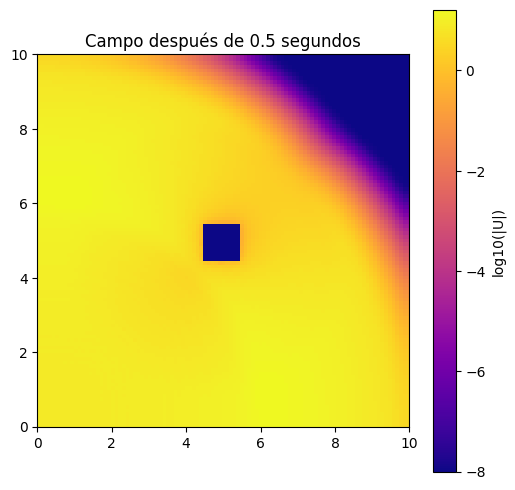

In [2]:
import numpy as np                      # Librería para cálculo numérico
import matplotlib.pyplot as plt        # Librería para visualización

# --- Parámetros del dominio espacial y temporal ---
L = 10.0                # Longitud del lado del cuarto en metros
Nx = 101                # Número de puntos en la malla por eje
dx = L / (Nx - 1)       # Tamaño del paso espacial
dt = 0.001              # Paso de tiempo (en segundos)
T = 0.5                 # Tiempo total de simulación
Nt = int(T / dt)        # Número total de pasos de tiempo
v = 20.0                # Velocidad de propagación de la onda (m/s)
c = v * dt / dx         # Número de Courant
assert c < 1            # Verificación de estabilidad numérica

# --- Inicialización de los campos (estado previo, actual y siguiente) ---
U_prev = np.zeros((Nx, Nx))   # Campo en el instante t - dt
U = np.zeros((Nx, Nx))        # Campo en el instante actual t
U_next = np.zeros((Nx, Nx))   # Campo en el siguiente instante t + dt

# --- Fuente puntual: posición del router WiFi ---
source_position = (2, 2)      # Coordenadas de la fuente (esquina inferior izquierda)

# --- Función de la fuente: pulso fuerte durante los primeros 200 pasos ---
def fuente(n):
    return 1e6 if n < 200 else 0

# --- Función que aplica un obstáculo metálico en el centro del cuarto ---
def aplicar_columna(U):
    centro = Nx // 2                  # Centro de la malla
    ancho = int(1.0 / dx)             # Ancho de 1 metro convertido a celdas
    r = ancho // 2                    # Radio del cuadrado metálico
    U[centro - r:centro + r, centro - r:centro + r] = 0.0  # Se anula el campo en esa zona

# --- Función que aplica condiciones de frontera reflejantes ---
def reflejar(U):
    U[0,:] = U[1,:]       # Borde izquierdo
    U[-1,:] = U[-2,:]     # Borde derecho
    U[:,0] = U[:,1]       # Borde inferior
    U[:,-1] = U[:,-2]     # Borde superior

# --- Bucle principal de la simulación ---
for n in range(Nt):
    # Actualizar el campo U usando diferencias finitas (laplaciano)
    for i in range(1, Nx - 1):
        for j in range(1, Nx - 1):
            laplaciano = (U[i+1,j] + U[i-1,j] + U[i,j+1] + U[i,j-1] - 4*U[i,j]) / dx**2
            U_next[i,j] = 2 * U[i,j] - U_prev[i,j] + v**2 * dt**2 * laplaciano

    # Aplicar la fuente en su posición
    i_src, j_src = source_position
    U_next[i_src, j_src] += dt**2 * fuente(n)

    # Aplicar condiciones de frontera y obstáculo
    reflejar(U_next)
    aplicar_columna(U_next)

    # Avanzar en el tiempo (actualizar matrices)
    U_prev[:], U[:] = U[:], U_next[:]

# --- Mostrar el resultado final después de 0.5 s ---
plt.figure(figsize=(6,6))
plt.imshow(np.log10(np.abs(U)+1e-8), cmap='plasma', extent=[0, L, 0, L], origin='lower')
plt.title('Campo después de 0.5 segundos')      # Título del gráfico
plt.colorbar(label='log10(|U|)')                # Barra de colores
plt.show()                                      # Mostrar gráficoX


Para guardar la información de U(r,t) (siendo este el calor en determinado espacio y tiempo) podemos utilizar una matriz, de forma que, al usar la función de forma discreta, tenemos cada valor de U acomodado respecto a r y t.

Para especificar las condiciones iniciales, debemos agregar un valor dentro de la matriz U(r,t), donde r = 0, y t = 0. Por ejemplo, puede iniciarse U como una matriz de 0s.

Para modelar la fuente, podemos usar un valor en una posición inicial, y luego modelar el cambio de su intensidad respecto al tiempo.  Esto puede ser por medio de una función de pulso gaussiano.

Podemos introducir esta fuente al algoritmo, si a cada valor en r posición y t tiempo de la matriz se suma la fuente.

Algo como
Unew[i,j] = dt**2 * f(n)

donde f es la fuente, que depende de cada n

<ipython-input-3-b695ed06f752>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


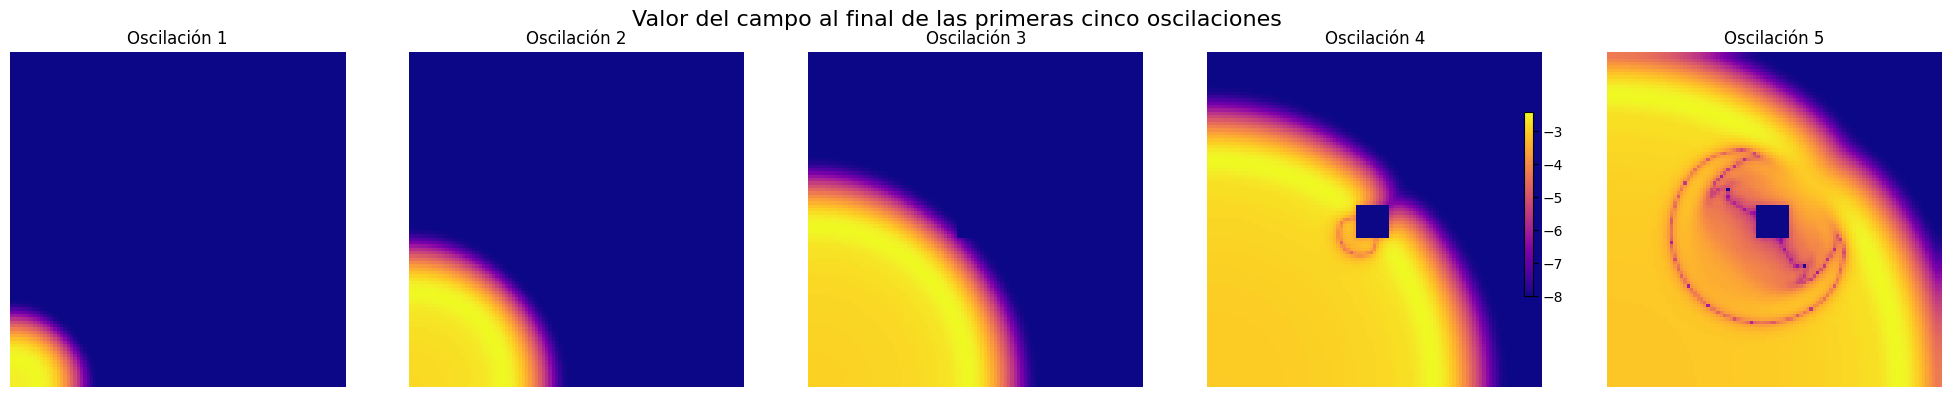

In [ ]:
import numpy as np                      # Librería para cálculos numéricos
import matplotlib.pyplot as plt        # Librería para graficar

# --- Parámetros espaciales ---
L = 10.0                                # Longitud del lado del cuarto (en metros)
Nx = 101                                # Número de puntos en cada eje (resolución)
dx = L / (Nx - 1)                       # Paso espacial
x = np.linspace(0, L, Nx)               # Vector de coordenadas en x
y = np.linspace(0, L, Nx)               # Vector de coordenadas en y

# --- Parámetros temporales ---
dt = 0.001                              # Paso de tiempo (en segundos)
T = 2.0                                 # Tiempo total de simulación
Nt = int(T / dt)                        # Número total de pasos de tiempo

# --- Velocidad de propagación ---
v = 20.0                                # Velocidad de la onda (m/s)
c = v * dt / dx                         # Número de Courant (para estabilidad)
assert c < 1, "¡El esquema no es estable! Baja v, sube dx o baja dt."  # Verificación de estabilidad

# --- Inicialización de matrices para el campo U ---
U_prev = np.zeros((Nx, Nx))             # Campo en t - dt
U = np.zeros((Nx, Nx))                  # Campo en t
U_next = np.zeros((Nx, Nx))             # Campo en t + dt

# --- Fuente (posición del router WiFi) ---
source_position = (2, 2)                # Coordenadas de la fuente (cerca de la esquina)
def fuente(n):
    return 1000.0 * np.exp(-((n*dt - 0.05)**2) / (2 * 0.01**2))  # Pulso tipo gaussiano

# --- Función que simula el obstáculo (columna metálica en el centro) ---
def aplicar_columna(U):
    centro = Nx // 2                    # Coordenada central
    ancho = int(1.0 / dx)               # Ancho del obstáculo en celdas
    r = ancho // 2                      # Mitad del ancho (radio)
    U[centro - r:centro + r, centro - r:centro + r] = 0.0  # Se anula el campo dentro de la columna

# --- Condiciones de frontera reflejantes ---
def reflejar(U):
    U[0,:] = U[1,:]                     # Reflejo borde izquierdo
    U[-1,:] = U[-2,:]                   # Reflejo borde derecho
    U[:,0] = U[:,1]                     # Reflejo borde inferior
    U[:,-1] = U[:,-2]                   # Reflejo borde superior

# --- Tiempos donde se desea guardar el campo para cada oscilación ---
osc_period = 0.1                                            # Duración aproximada de una oscilación
frames_objetivo = [int((i+1)*osc_period/dt) for i in range(5)]  # Tiempos de las primeras cinco oscilaciones
campos = []                                                 # Lista para guardar los campos

# --- Bucle de evolución temporal ---
for n in range(max(frames_objetivo) + 1):                   # Simula hasta el último frame necesario
    for i in range(1, Nx - 1):
        for j in range(1, Nx - 1):
            laplaciano = (U[i+1,j] + U[i-1,j] + U[i,j+1] + U[i,j-1] - 4*U[i,j]) / dx**2
            U_next[i,j] = 2 * U[i,j] - U_prev[i,j] + v**2 * dt**2 * laplaciano

    # Aplicar fuente en su posición
    i_src, j_src = source_position
    U_next[i_src, j_src] += dt**2 * fuente(n)

    # Aplicar condiciones de frontera y obstáculo
    reflejar(U_next)
    aplicar_columna(U_next)

    # Guardar el campo si estamos en uno de los tiempos objetivo
    if n in frames_objetivo:
        campos.append(U.copy())

    # Avanzar en el tiempo
    U_prev[:], U[:] = U[:], U_next[:]

# --- Visualización de los campos guardados ---
fig, axes = plt.subplots(1, 5, figsize=(20, 4))                     # Crear 5 subplots
for i in range(5):
    im = axes[i].imshow(np.log10(np.abs(campos[i]) + 1e-8),         # Mapa de calor con escala logarítmica
                        cmap='plasma', extent=[0, L, 0, L], origin='lower')
    axes[i].set_title(f'Oscilación {i+1}')                          # Título por oscilación
    axes[i].axis('off')                                            # Quitar ejes para estética

fig.suptitle("Valor del campo al final de las primeras cinco oscilaciones", fontsize=16)  # Título general
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)             # Barra de color compartida
plt.tight_layout()                                                 # Ajuste automático de espaciado
plt.show()                                                         # Mostrar figura


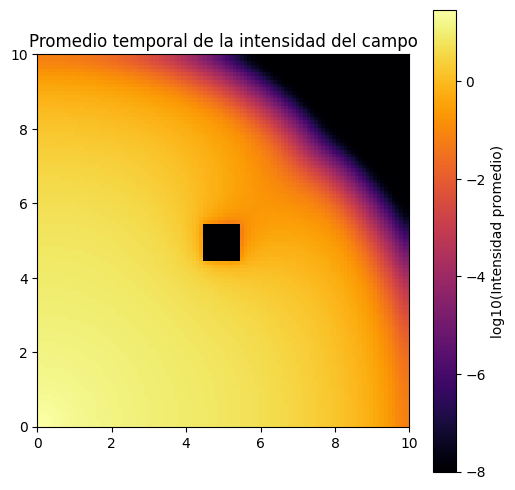

In [ ]:
# --- Reiniciar campos para nueva simulación ---
U_prev = np.zeros((Nx, Nx))           # Campo en t - dt
U = np.zeros((Nx, Nx))                # Campo en t
U_next = np.zeros((Nx, Nx))           # Campo en t + dt
acumulador = np.zeros((Nx, Nx))       # Matriz donde se acumulará |U| en cada paso de tiempo

# --- Nueva simulación para promedio temporal ---
for n in range(Nt):                   # Recorremos todos los pasos de tiempo
    for i in range(1, Nx - 1):
        for j in range(1, Nx - 1):
            # Cálculo del laplaciano con diferencias finitas
            laplaciano = (U[i+1,j] + U[i-1,j] + U[i,j+1] + U[i,j-1] - 4*U[i,j]) / dx**2
            # Ecuación de onda: actualización del campo
            U_next[i,j] = 2 * U[i,j] - U_prev[i,j] + v**2 * dt**2 * laplaciano

    # Aplicamos la fuente gaussiana en la esquina inferior izquierda
    i_src, j_src = source_position
    U_next[i_src, j_src] += dt**2 * fuente(n)

    # Aplicamos condiciones de frontera reflejantes
    reflejar(U_next)
    # Aplicamos el obstáculo metálico central
    aplicar_columna(U_next)

    # Acumulamos la intensidad absoluta del campo en cada celda
    acumulador += np.abs(U)

    # Avanzamos en el tiempo: U_prev ← U, U ← U_next
    U_prev[:], U[:] = U[:], U_next[:]

# --- Cálculo del promedio temporal de la intensidad ---
promedio = acumulador / Nt            # Se divide entre el número de pasos para obtener el promedio

# --- Mostrar el mapa de calor del promedio ---
plt.figure(figsize=(6, 6))            # Tamaño de la figura
plt.imshow(np.log10(promedio + 1e-8), # Usamos escala logarítmica para ver valores pequeños
           cmap='inferno',            # Colormap con buen contraste
           extent=[0, L, 0, L], origin='lower')  # Coordenadas físicas
plt.title("Promedio temporal de la intensidad del campo")  # Título del gráfico
plt.colorbar(label="log10(Intensidad promedio)")           # Barra de color con etiqueta
plt.show()                          # Mostrar figura
